# Plot Sample Locations

Goal here is to create a simple plot showing sample locations

## Import packages

In [11]:
# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

# math
from shapely.geometry import Point, box


## Setup

In [12]:
# Set filepaths

path_to_data = '../../data/'
path_to_samples = '../../data/sampling/master/'
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/dip_adjusted_samples/'

## Load data

In [13]:
# load metadata
df = pd.read_excel(path_to_data + 'sampling/metadata.xlsx')

## Make the plots
Thanks Chat-GPT for the code below - enjoying the new o4 mini

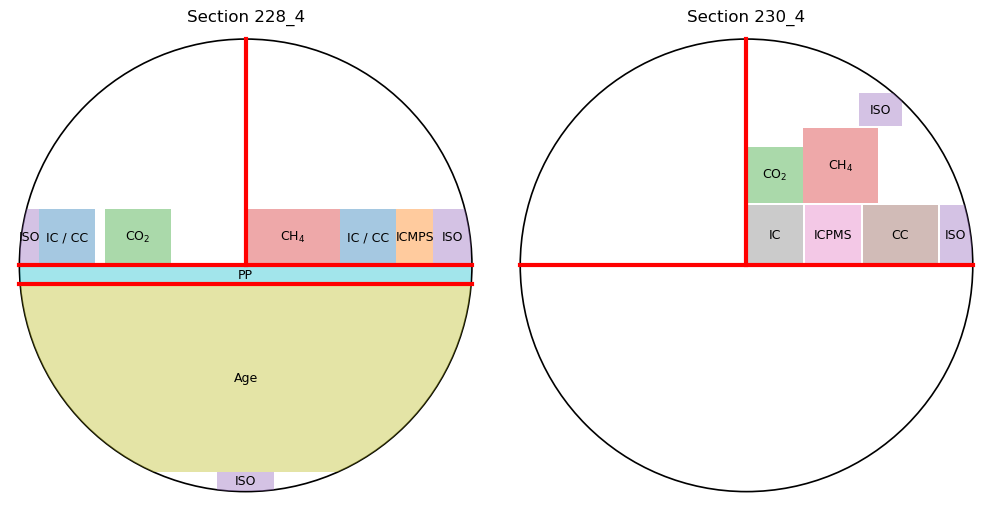

In [14]:
sections = df['section'].unique()
n = len(sections)
cols = min(3, n)
rows = int(np.ceil(n/cols))

fig, axs = plt.subplots(rows, cols,
                        figsize=(5*cols, 5*rows),
                        constrained_layout=True)
axs = axs.flatten()

# build a color map per meas_type
types = df['meas_type'].unique()
cmap = plt.get_cmap('tab10')
color_map = {t: cmap(i) for i, t in enumerate(types)}

radius = 241/2  # 120.5
center = (0, 0)

for ax, sec in zip(axs, sections):
    sub = df[df['section'] == sec]

    # 1) draw the circle at the origin
    circ = patches.Circle(center, radius,
                          edgecolor='black',
                          facecolor='none',
                          linewidth=1.2)
    ax.add_patch(circ)

    # 2) for each subsample, shift coords and clip to circle
    for _, row in sub.iterrows():
        x0 = row['x_lo']
        y0 = row['y_lo']
        w = row['x_hi'] - row['x_lo']
        h = row['y_hi'] - row['y_lo']

        rect = patches.Rectangle((x0, y0), w, h,
                                 facecolor=color_map[row['meas_type']],
                                 alpha=0.4,
                                 edgecolor='none')
        # clip rectangle to circle
        rect.set_clip_path(circ)
        ax.add_patch(rect)

        # label at rect center (still placed relative to full box)
        ax.text(x0 + w/2,
                y0 + h/2,
                row['meas_type'],
                ha='center',
                va='center',
                fontsize=9)

    ax.set_aspect('equal')
    ax.set_xlim(-radius-5, radius+5)
    ax.set_ylim(-radius-5, radius+5)
    ax.set_title(f'Section {sec}')
    #ax.grid()
    ax.axis('off')

# add ECM
for ax in axs:
    ax.plot([-120.5, 120.5], [0, 0], color='red', linewidth=3)
    ax.plot([0, 0], [0, 120.5], color='red', linewidth=3)
axs[0].plot([-120.5, 120.5], [-10, -10], color='red', linewidth=3)


# hide unused subplots
for ax in axs[n:]:
    ax.axis('off')

plt.show()

In [15]:
radius = 241/2  # 120.5
circle = Point(0, 0).buffer(radius, resolution=64)

def effective_center(row):
    # build the rectangle
    rect = box(row['x_lo'], row['y_lo'],
               row['x_hi'], row['y_hi'])
    # intersect with circle
    clipped = rect.intersection(circle)
    if clipped.is_empty:
        # no overlap → NaN; or you can choose to fallback to midpoint:
        return pd.Series({'x_center': np.nan,
                          'y_center': np.nan})
    # centroid of the clipped shape
    c = clipped.centroid
    return pd.Series({'x_center': c.x,
                      'y_center': c.y})

# apply across the DataFrame
df[['x_center', 'y_center']] = df.apply(effective_center, axis=1)